# Correlation between PAR and lifespan
This notebook contains code for analyzing the associations between mortality (i.e. deceased SardiNIA participants) and their PAR values.

In [1]:
import numpy as np
import matplotlib.pyplot as pl
from scipy.stats import pearsonr
import random
from scipy.stats import ttest_ind, ttest_1samp
import pandas as pd
import math

## Random age-matched partner t-test

Each deceased subject is randomly age-matched with an individual of the same age from the living subjects group. We then perform a one-tailed, one-sample t-test on the differences in PARs for each pair (e.g. $\Delta $PAR$=$PAR$_{\text{deceased}}-$PAR$_{\text{living}}$.)

In [25]:
def RandomPartner (results_path='./Results/SardiNIA/wave1_normal_rf.tsv', deceased_path='Death_progenia 20190731.csv', N=100,
                  match_sex=False, delta_age=0.5):
    '''
    Random living, age-matched partner selection for each deceased individual. Runs one-sided, one-sample t-test on
    the difference in the mean PARs between the two groups.
    
    old deceased_path = './deceduti_Deaths 2001-2017.csv'
    match_sex [boolean] = whether to match subjects by sex as well as age
    delta_age [float] = half-width of age interval for age-matching (i.e. partnered with subjects within +- delta_age)
    '''
    # Read in PAR from file
    data = np.genfromtxt(results_path, delimiter='\t')
    ids = data[:,0]
    chron = data[:,1]
    pred = data[:,2]
    PAR = pred/chron

    # Read in deceased id's from file
    deaths = np.genfromtxt(deceased_path, delimiter=',')
    dec_ids = deaths[:,0]
    
    # Get sex from W1 data
    w1_df = pd.read_csv('./RawData/2013-12-18-Sardinia-CleanUp-Data-Wave1.tsv', sep='\t')
    w1_ids = list(w1_df['id_individual'])
    w1_sex = list(w1_df['Sex'])
    sex = []
    for i in range(len(ids)): # get PAR subject sex
        if ids[i] in w1_ids:
            idx = w1_ids.index(ids[i])
            sex.append(w1_sex[idx])
        else:
            sex.append(2) # sex unknown
    sex = np.array(sex)

    # Get deceased ages and PARs
    dec_PAR = []
    dec_age = []
    dec_sex = []
    
    for i in range(len(ids)):
        if ids[i] in dec_ids:
            dec_PAR.append(PAR[i])
            dec_age.append(chron[i])
            dec_sex.append(sex[i])
            
    print ('Number of deceased used: '+str(len(dec_PAR))+'/'+str(len(dec_ids)))
    print ('Age range of deceased: '+str(np.min(dec_age))+'-'+str(np.max(dec_age)))
    
    # Run random age-matched partner t-test
    delta_PAR = []
    p_vals = []
    
    for n in range(N):
        # Get control age-matched partners
        partner_PAR = []
        new_dec_PAR = []
        
        for i, age in enumerate(dec_age):
            if match_sex is False:
                matched_idxs = np.where((chron >= age-delta_age) & (chron <=age+delta_age))[0] 
            else:
                matched_idxs = np.where((chron >= age-delta_age) & (chron <=age+delta_age) & (sex == dec_sex[i]))[0]
            rand_idx = random.choice(matched_idxs)
            cnt = 0
            while ids[rand_idx] in dec_ids and cnt<5: # continue drawing if partner is also deceased
                rand_idx = random.choice(matched_idxs)
                cnt += 1
            if cnt == 5:
                continue
            partner_PAR.append(PAR[rand_idx])
            new_dec_PAR.append(dec_PAR[i])

        # Perform two sample t-test on means
        d_par = np.mean(new_dec_PAR)-np.mean(partner_PAR)
        #t, p = ttest_ind(new_dec_PAR, partner_PAR) # two-sample
        t, p = ttest_1samp(np.array(new_dec_PAR)-np.array(partner_PAR), 0, nan_policy='omit') # two-tailed one-sample
        if t > 0: # get one-tailed
            p = p/2
        else:
            p = 1-p/2
        
        if len(new_dec_PAR)!=len(partner_PAR):
            raise Exception('Living and deceased group sizes do not match!')
        
        delta_PAR.append(d_par)
        p_vals.append(p)
    
    return (delta_PAR, p_vals)

In [27]:
delt_pars, pvals = RandomPartner(N=10000, match_sex=True, delta_age=1.0)

Number of deceased used: 265/593
Age range of deceased: 16.3-76.7
(array([   0,    1,    2, ..., 4739, 4741, 4742], dtype=int64),)


Fraction p<0.05 = 0.867
Mean Delta PAR = 0.01842447914377192
Fraction Delta PAR < 0 = 0.0007


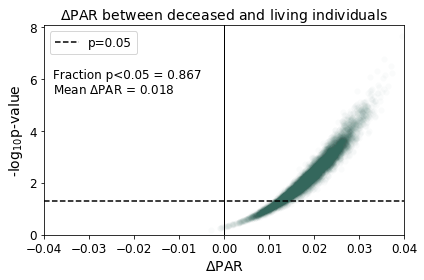

In [28]:
sig_count = 0
for p in pvals:
    if p < 0.05:
        sig_count += 1
        
neg_count = 0
for delt in delt_pars:
    if delt < 0:
        neg_count += 1
        
print ('Fraction p<0.05 = ' + str(sig_count/len(pvals)))
print ('Mean Delta PAR = ' + str(np.mean(delt_pars)))
print ('Fraction Delta PAR < 0 = ' +str(neg_count/len(delt_pars)))

#pl.scatter(-np.log2(delt_pars), -np.log10(pvals),alpha=0.02)
pl.title('$\Delta$'+'PAR between deceased and living individuals', fontsize=14)
pl.scatter(delt_pars, -np.log10(pvals),edgecolor='#34675C',color='#34675C',linewidth=0.0,alpha=0.025)
pl.axhline(y=-np.log10(0.05), xmin=0, xmax=1.0, linewidth=1.5, color='k', linestyle='--', label='p=0.05')
pl.axvline(x=0, ymin=0, ymax=1.0, linewidth=1.0, color = 'k')
#pl.xlabel('-log'+'$_{2}\Delta$' + 'PAR', fontsize=14)
pl.xlim(-0.04, 0.04)
pl.ylim(-0.01, None)
pl.xlabel('$\Delta$' + 'PAR', fontsize=14)
pl.ylabel('-log'+'$_{10}$'+'p-value', fontsize=14)
pl.tick_params(axis='both', which='major', labelsize=12)
pl.tick_params(axis='both', which='minor', labelsize=12)
pl.annotate('Fraction p<0.05 = ' + str("%.3f" %(sig_count/len(pvals))), xy=(0.025, 0.75), xycoords='axes fraction', fontsize=12)
pl.annotate('Mean '+'$\Delta$'+'PAR = ' + str("%.3f" %(np.mean(delt_pars))), xy=(0.025, 0.675), xycoords='axes fraction', fontsize=12)
pl.legend(loc='upper left', fontsize=12)
pl.tight_layout()
pl.savefig('./Figures/mortality_sexmatched_delta1.png', dpi=800)
pl.show()

# Randomized control

A randomized control pairing where two age-matched subjects are chosen and split into two groups of the same size as the deceased population but without regard for the living statuses of the age-matched partners.

In [29]:
def RandomControl (results_path='./Results/SardiNIA/wave1_normal_rf.tsv', deceased_path='Death_progenia 20190731.csv', N=100,
                  match_sex=False, delta_age=0.5):
    '''
    Performs an age-matched, randomized pairing of living participants as a control for the RandomPartner() simulation.
    Performs the same statistical tests for significance in the mean PAR between the two groups
    
    match_sex [boolean] = whether to match subjects by sex as well as age
    delta_age [float] = half-width of age interval for age-matching (i.e. partnered with subjects within +- delta_age)
    '''
    # Read in PAR from file
    data = np.genfromtxt(results_path, delimiter='\t')
    ids = data[:,0]
    chron = data[:,1]
    pred = data[:,2]
    PAR = pred/chron

    # Read in deceased id's from file
    deaths = np.genfromtxt(deceased_path, delimiter=',')
    dec_ids = deaths[:,0]

    # Get sex from W1 data
    w1_df = pd.read_csv('./RawData/2013-12-18-Sardinia-CleanUp-Data-Wave1.tsv', sep='\t')
    w1_ids = list(w1_df['id_individual'])
    w1_sex = list(w1_df['Sex'])
    sex = []
    for i in range(len(ids)): # get PAR subject sex
        if ids[i] in w1_ids:
            idx = w1_ids.index(ids[i])
            sex.append(w1_sex[idx])
        else:
            sex.append(2) # sex unknown
    sex = np.array(sex)
    
    # Get deceased ages and PARs
    dec_PAR = []
    dec_age = []
    dec_sex = []
    
    for i in range(len(ids)):
        if ids[i] in dec_ids:
            dec_PAR.append(PAR[i])
            dec_age.append(chron[i])
            dec_sex.append(sex[i])
    
    # Run random age-matched partner t-test
    delta_PAR = []
    p_vals = []
    
    for n in range(N):
        # Get two control age-matched partners
        partner1_PAR = []
        partner2_PAR = []
        for age in dec_age:
            if match_sex is False:
                matched_idxs = np.where((chron >= age-delta_age) & (chron <=age+delta_age))[0] 
            else:
                matched_idxs = np.where((chron >= age-delta_age) & (chron <=age+delta_age) & (sex == dec_sex[i]))[0]
            rand_idxs = [random.choice(matched_idxs)]
            cnt = 0
            while cnt<5 and len(rand_idxs)<2:
                rand_idx = random.choice(matched_idxs)
                if rand_idx not in rand_idxs:
                    rand_idxs.append(rand_idx)
                cnt += 1
            if len(rand_idxs) < 2 or cnt==5:
                continue
            partner1_PAR.append(PAR[rand_idxs[0]])
            partner2_PAR.append(PAR[rand_idxs[1]])

        # Perform two sample t-test on means
        d_par = np.mean(partner1_PAR)-np.mean(partner2_PAR)
        #t, p = ttest_ind(partner1_PAR, partner2_PAR)
        t, p = ttest_1samp(np.array(partner1_PAR)-np.array(partner2_PAR), 0, nan_policy='omit') # two-tailed one-sample 
        if t > 0: # get one-tailed
            p = p/2
        else:
            p = 1-p/2
            
        if len(partner1_PAR)!=len(partner2_PAR):
            raise Exception('Living and deceased group sizes do not match!')
        
        delta_PAR.append(d_par)
        p_vals.append(p)
    
    return (delta_PAR, p_vals)

In [30]:
delt_pars, pvals = RandomControl(N=10000)

Fraction p<0.05 = 0.0477
Mean Delta PAR = 7.662898277695099e-05
Fraction Delta PAR < 0 = 0.4933


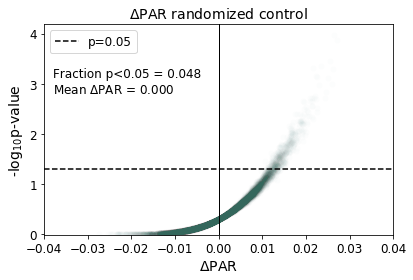

In [31]:
sig_count = 0
for p in pvals:
    if p < 0.05:
        sig_count += 1

        neg_count = 0
for delt in delt_pars:
    if delt < 0:
        neg_count += 1
        
print ('Fraction p<0.05 = ' + str(sig_count/len(pvals)))
print ('Mean Delta PAR = ' + str(np.mean(delt_pars)))
print ('Fraction Delta PAR < 0 = ' +str(neg_count/len(delt_pars)))

#pl.scatter(-np.log2(delt_pars), -np.log10(pvals),alpha=0.02)
pl.title('$\Delta$'+'PAR randomized control', fontsize=14)
pl.scatter(delt_pars, -np.log10(pvals),edgecolor='#34675C',color='#34675C',linewidth=0.0,alpha=0.01)
pl.axhline(y=-np.log10(0.05), xmin=0, xmax=1.0, linewidth=1.5, color='k', linestyle='--', label='p=0.05')
pl.axvline(x=0, ymin=0, ymax=1.0, linewidth=1.0, color = 'k')
#pl.xlabel('-log'+'$_{2}\Delta$' + 'PAR', fontsize=14)
pl.xlim(-0.04, 0.04)
pl.ylim(-0.01, None)
pl.xlabel('$\Delta$' + 'PAR', fontsize=14)
pl.ylabel('-log'+'$_{10}$'+'p-value', fontsize=14)
pl.tick_params(axis='both', which='major', labelsize=12)
pl.tick_params(axis='both', which='minor', labelsize=12)
pl.annotate('Fraction p<0.05 = ' + str("%.3f" %(sig_count/len(pvals))), xy=(0.025, 0.75), xycoords='axes fraction', fontsize=12)
pl.annotate('Mean '+'$\Delta$'+'PAR = ' + str("%.3f" %(np.mean(delt_pars))), xy=(0.025, 0.675), xycoords='axes fraction', fontsize=12)
pl.legend(loc='upper left', fontsize=12)
pl.tight_layout()
pl.savefig('./Figures/mortality_control_sexmatched_delta1.png', dpi=800)
pl.show()

# Results for 65-trait model

Number of deceased used: 329/593
Age range of deceased: 16.3-76.9
Fraction p<0.05 = 0.6569
Mean Delta PAR = 0.013536606617995727
Fraction Delta PAR < 0 = 0.0039


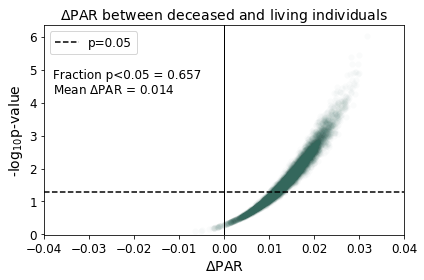

In [41]:
delt_pars, pvals = RandomPartner (results_path='./Results/SardiNIA/wave1_common_rf.tsv', deceased_path='./Death_progenia 20190731.csv', N=10000)

sig_count = 0
for p in pvals:
    if p < 0.05:
        sig_count += 1
        
neg_count = 0
for delt in delt_pars:
    if delt < 0:
        neg_count += 1
        
print ('Fraction p<0.05 = ' + str(sig_count/len(pvals)))
print ('Mean Delta PAR = ' + str(np.mean(delt_pars)))
print ('Fraction Delta PAR < 0 = ' +str(neg_count/len(delt_pars)))

#pl.scatter(-np.log2(delt_pars), -np.log10(pvals),alpha=0.02)
pl.title('$\Delta$'+'PAR between deceased and living individuals', fontsize=14)
pl.scatter(delt_pars, -np.log10(pvals),edgecolor='#34675C',color='#34675C',linewidth=0.0,alpha=0.025)
pl.axhline(y=-np.log10(0.05), xmin=0, xmax=1.0, linewidth=1.5, color='k', linestyle='--', label='p=0.05')
pl.axvline(x=0, ymin=0, ymax=1.0, linewidth=1.0, color = 'k')
#pl.xlabel('-log'+'$_{2}\Delta$' + 'PAR', fontsize=14)
pl.xlim(-0.04, 0.04)
pl.ylim(-0.01, None)
pl.xlabel('$\Delta$' + 'PAR', fontsize=14)
pl.ylabel('-log'+'$_{10}$'+'p-value', fontsize=14)
pl.tick_params(axis='both', which='major', labelsize=12)
pl.tick_params(axis='both', which='minor', labelsize=12)
pl.annotate('Fraction p<0.05 = ' + str("%.3f" %(sig_count/len(pvals))), xy=(0.025, 0.75), xycoords='axes fraction', fontsize=12)
pl.annotate('Mean '+'$\Delta$'+'PAR = ' + str("%.3f" %(np.mean(delt_pars))), xy=(0.025, 0.675), xycoords='axes fraction', fontsize=12)
pl.legend(loc='upper left', fontsize=12)
pl.tight_layout()
pl.savefig('./Figures/mortality_65.png', dpi=800)
pl.show()

# Correlation between lifespan (years)

In [2]:
def get_lifespan_pars (wave_file='RawData/2013-12-18-Sardinia-CleanUp-Data-Wave1.tsv',
                   par_file = './Results/SardiNIA/wave1_normal_rf.tsv',
                   death_file='./Death_progenia 20190731.csv',
                   method='year',
                   age_threshold=0):
    '''
    Gets the lifespans based on death dates and a given SardiNIA study file for all inviduals present in both.
    Also returns the corresponding PAR values from a PAR file.
    
    method [str] = 'year' : calculate given year (with error of +- 1 year)
                   'month' : calculate by month (with error of approx. +-0.1 year)
    '''
    # Read in date and age information
    wave1_df = pd.read_csv(wave_file,sep='\t')
    age_ids = list(wave1_df['id_individual'])
    ages = list(wave1_df['Age'])
    visit_date = list(wave1_df['FirstVisitDate'])
    #visit_year = [date.split('-')[0] if type(date) is str else 'nan' for date in visit_date]
    
    # Read in PARs
    data = np.genfromtxt(par_file, delimiter='\t')
    par_ids = data[:,0].tolist()
    chron = data[:,1]
    pred = data[:,2]
    PAR = pred/chron
    
    # Read in deceased subject IDs and date at death
    deaths = np.genfromtxt(death_file, delimiter=',',dtype='unicode')
    dec_ids = deaths[:,0]
    dec_dates = deaths[:,1]
    
    # Match ID's and then get lifespans and PARs
    new_ids = []
    lifespans = []
    pars = []
                
    for dec_idx, dec_id in enumerate(dec_ids):
        if not dec_dates[dec_idx] or dec_idx==0: # skip if missing date and if first entry
            continue
        else:
            # get age and agedate
            if int(dec_id) not in age_ids: # skip if ids not matching
                continue
            if int(dec_id) not in par_ids: # skip if ids not matching
                continue
            age_idx = age_ids.index(int(dec_id))
            age = ages[age_idx]
            if age < age_threshold: # only use individuals past a certain age (to control for edge effect)
                continue
            agedate = visit_date[age_idx]
            if agedate == 'nan': # skip if visit date missing
                continue
            if '-' not in agedate: # check that date is good
                print ('- issue')
            # get deathdate
            deathdate = dec_dates[dec_idx]
            if '-' in deathdate and method=='month': # check if not month format
                input_method = 'month'
            elif '-' in deathdate and method=='year': # convert to year
                input_method = 'year'
                deathdate = '20'+deathdate.split('-')[2]
                agedate = agedate.split('-')[0]
            else:
                input_method = 'year'
                agedate = agedate.split('-')[0]

            # get lifespan
            lifespan = calculate_lifespan(age, agedate, deathdate, input_method)
            #if lifespan>1000:
            #    print (deathdate)
            #    print (agedate)
            lifespans.append(lifespan)
            # get PAR
            par_idx = par_ids.index(float(dec_id))
            pars.append(PAR[par_idx])
            new_ids.append(dec_id)
        
    return (new_ids, pars, lifespans)
    
    

def calculate_lifespan (age, agedate, deathdate, method='year'):
    '''
    Calculates lifespan from birthdate and deathdate
    
    age [float] = age at agedate
    agedate [str] = date corresponding to age measurement as a year ('####') or as date ('####-##-##') (month then date)
    deathdate [str] = date of death as a year ('####') or as date ('##-XXX-(20)##')
    method [str] = 'year' : calculate given year (with error of +- 1 year)
                   'month' : calculate by month (with error of approx. +-0.1 year)
    '''
    year_fraction_map = {'Jan':1/12,'Feb':2/12,'Mar':3/12,'Apr':4/12,'May':5/12,'Jun':6/12,'Jul':7/12,
                        'Aug':8/12,'Sep':9/12,'Oct':10/12,'Nov':11/12,'Dec':12/12}
    
    # Calculate elapsed time
    if method is 'year':
        deathdate = deathdate
        elapsed_time = float(deathdate)-float(agedate)
        
    elif method is 'month':
        age_month = agedate.split('-')[1]
        age_year = agedate.split('-')[0]
        age_year_frac = float(age_month)/12
        age_year = float(age_year) + float(age_year_frac)
        
        death_month = deathdate.split('-')[1]
        death_year = '20'+deathdate.split('-')[2]
        death_year_frac = year_fraction_map[death_month]
        death_year = float(death_year) + float(death_year_frac)
        
        elapsed_time = death_year - age_year
    
    # Calculate lifespan
    lifespan = age + elapsed_time
    
    return (lifespan)

In [24]:
ids, pars, lifespans = get_lifespan_pars(method='month', age_threshold=0)

In [25]:
print (min(lifespans))
print (max(lifespans))

22.716666666666743
91.76666666666674


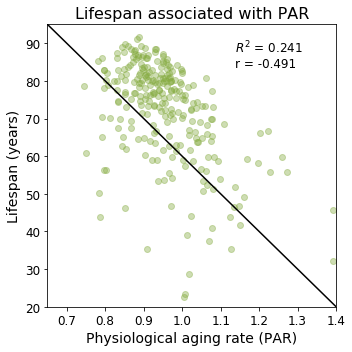

In [30]:
pearson, p = pearsonr(pars, lifespans)
pl.figure(figsize=(5,5))
pl.scatter(pars, lifespans,color='#86AC41',alpha=0.4)
pl.title('Lifespan associated with PAR', fontsize=16)
pl.ylabel('Lifespan (years)', fontsize=14)
pl.xlabel('Physiological aging rate (PAR)',fontsize=14)
pl.annotate('$R^2$ = '+str("%.3f" %(pearson*pearson)), xy=(0.65, 0.9), xycoords='axes fraction', fontsize=12)
pl.annotate('r = '+str("%.3f" %(pearson)), xy=(0.65, 0.85), xycoords='axes fraction', fontsize=12)
pl.tick_params(axis='both', which='major', labelsize=12)
pl.tick_params(axis='both', which='minor', labelsize=12)
pl.plot([0.65,1.4],[95,20],'k')
pl.xlim(0.65,1.4)
pl.ylim(20,95)
pl.tight_layout()
pl.savefig('./Figures/lifespan_PAR.png', dpi=800)
pl.show()

In [31]:
ids, pars, lifespans = get_lifespan_pars(method='month', par_file = './Results/SardiNIA/wave1_common_rf.tsv', age_threshold=0)
pearson, p = pearsonr(pars, lifespans)

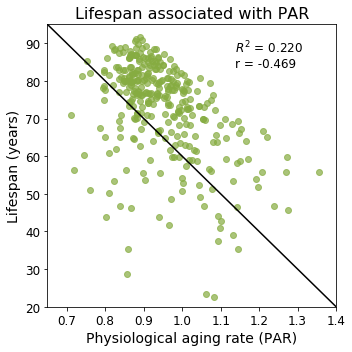

In [33]:
pl.figure(figsize=(5,5))
pl.scatter(pars, lifespans,color='#86AC41',alpha=0.7)
pl.title('Lifespan associated with PAR', fontsize=16)
pl.ylabel('Lifespan (years)', fontsize=14)
pl.xlabel('Physiological aging rate (PAR)',fontsize=14)
pl.annotate('$R^2$ = '+str("%.3f" %(pearson*pearson)), xy=(0.65, 0.9), xycoords='axes fraction', fontsize=12)
pl.annotate('r = '+str("%.3f" %(pearson)), xy=(0.65, 0.85), xycoords='axes fraction', fontsize=12)
pl.tick_params(axis='both', which='major', labelsize=12)
pl.tick_params(axis='both', which='minor', labelsize=12)
pl.plot([0.65,1.4],[95,20],'k')
pl.xlim(0.65,1.4)
pl.ylim(20,95)
pl.tight_layout()
pl.savefig('./Figures/lifespan_PAR_common.png', dpi=800)
pl.show()